# Explainable & Fair Intrusion Detection (UNSW-NB15)
## Full Technical Analysis Notebook

This notebook contains the complete, reproducible end-to-end machine learning workflow:
- Data exploration and preprocessing
- Feature engineering and dimensionality reduction
- Model training and evaluation
- Explainability (SHAP)
- Bias & fairness auditing

**Purpose:** Reproducible technical work for assessment and review.

In [40]:
## Step 2: Data Collection & Understanding

import pandas as pd

df = pd.read_csv("../data/UNSW_NB15.csv", low_memory=False)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [41]:
import os

OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

dataset_overview = pd.DataFrame({
    "rows": [df.shape[0]],
    "columns": [df.shape[1]],
    "memory_mb": [round(df.memory_usage(deep=True).sum() / (1024**2), 2)]
})

dataset_overview

,rows,columns,memory_mb
0,82332,45,44.84


In [42]:
dataset_overview.to_csv(
    os.path.join(OUTPUT_DIR, "dataset_overview.csv"),
    index=False
)

In [43]:
missing_count = df.isna().sum()
missing_pct = (missing_count / len(df) * 100).round(2)
unique_count = df.nunique(dropna=True)

sample_values = []
for col in df.columns:
    vals = df[col].dropna().unique()
    sample_values.append(", ".join(map(str, vals[:3])) if len(vals) else "")

data_dictionary = pd.DataFrame({
    "variable_name": df.columns,
    "dtype": df.dtypes.astype(str),
    "missing_count": missing_count.values,
    "missing_pct": missing_pct.values,
    "unique_count": unique_count.values,
    "sample_values": sample_values
})

data_dictionary["feature_type"] = data_dictionary["dtype"].apply(
    lambda x: "numeric" if "int" in x or "float" in x else "categorical"
)

data_dictionary.head(10)

,variable_name,dtype,missing_count,missing_pct,unique_count,sample_values,feature_type
id,id,int64,0,0.0,82332,"1, 2, 3",numeric
dur,dur,float64,0,0.0,39888,"1.1e-05, 8e-06, 5e-06",numeric
proto,proto,object,0,0.0,131,"udp, arp, tcp",categorical
service,service,object,0,0.0,13,"-, http, ftp",categorical
state,state,object,0,0.0,7,"INT, FIN, REQ",categorical
spkts,spkts,int64,0,0.0,420,"2, 1, 10",numeric
dpkts,dpkts,int64,0,0.0,436,"0, 6, 8",numeric
sbytes,sbytes,int64,0,0.0,4489,"496, 1762, 1068",numeric
dbytes,dbytes,int64,0,0.0,4034,"0, 268, 354",numeric
rate,rate,float64,0,0.0,40616,"90909.0902, 125000.0003, 200000.0051",numeric


In [44]:
data_dictionary.to_csv(
    os.path.join(OUTPUT_DIR, "data_dictionary_auto.csv"),
    index=False
)

In [45]:
df["label"].value_counts(normalize=True)

label
1    0.5506
0    0.4494
Name: proportion, dtype: float64

In [46]:
## Step 3: Data Preprocessing, EDA & Feature Engineering

# Check missing values
df.isna().sum().sort_values(ascending=False).head()


id        0
dwin      0
synack    0
ackdat    0
smean     0
dtype: int64

In [47]:
# Check duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count

np.int64(0)

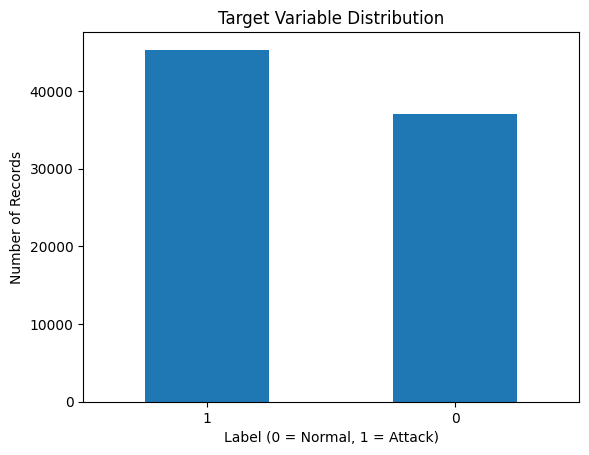

In [48]:
# Target Distribution Visualization
import matplotlib.pyplot as plt

label_counts = df["label"].value_counts()

label_counts.plot(kind="bar")
plt.title("Target Variable Distribution")
plt.xlabel("Label (0 = Normal, 1 = Attack)")
plt.ylabel("Number of Records")
plt.xticks(rotation=0)
plt.show()

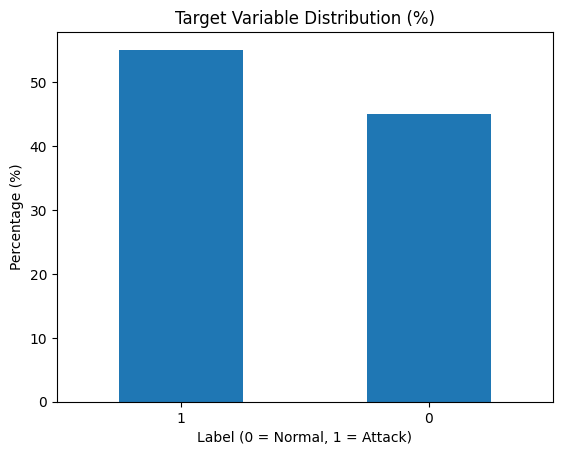

In [49]:
(df["label"].value_counts(normalize=True) * 100).plot(kind="bar")
plt.title("Target Variable Distribution (%)")
plt.xlabel("Label (0 = Normal, 1 = Attack)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.show()

In [50]:
# Numeric Feature Distributions
numeric_features = [
    "dur",      # connection duration
    "spkts",    # source packets
    "dpkts",    # destination packets
    "sbytes",   # source bytes
    "dbytes",   # destination bytes
    "rate"      # traffic rate
]

numeric_features

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate']

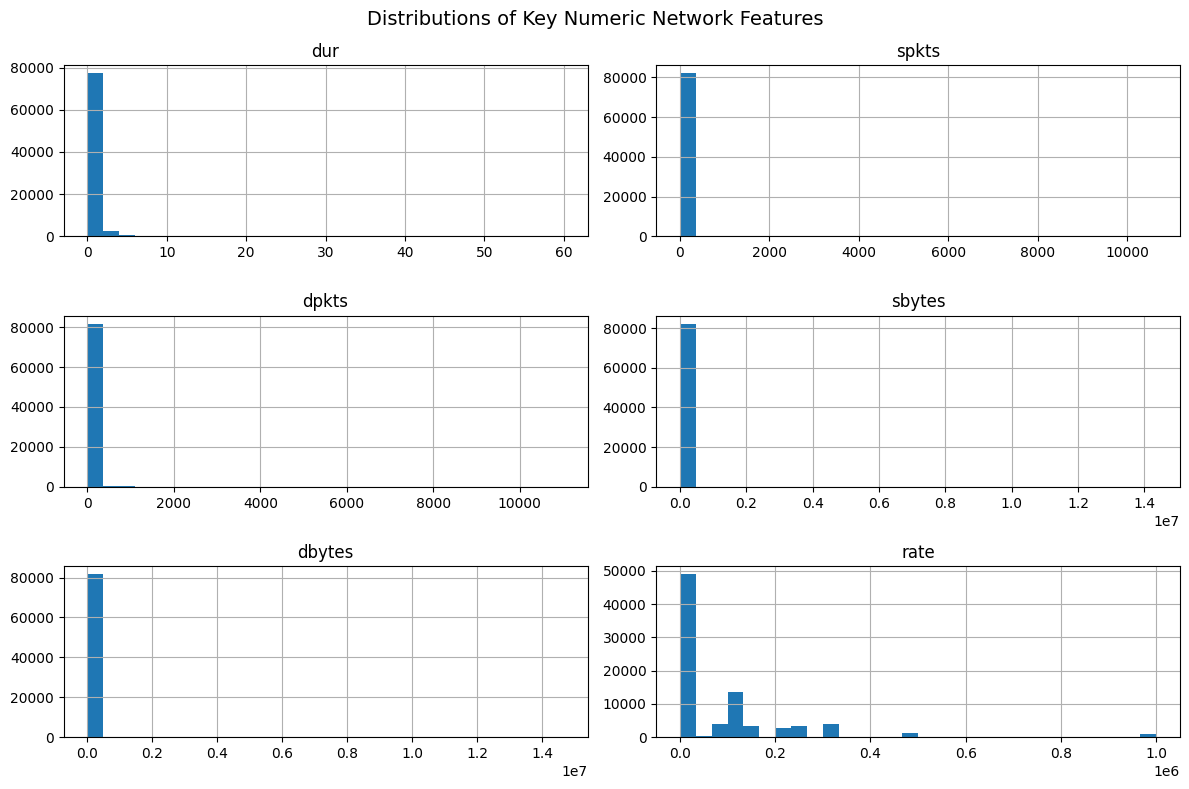

In [51]:
#Histogram Plots for Numeric Distributions
import matplotlib.pyplot as plt

df[numeric_features].hist(
    bins=30,
    figsize=(12, 8),
    layout=(3, 2)
)

plt.suptitle("Distributions of Key Numeric Network Features", fontsize=14)
plt.tight_layout()
plt.show()

In [52]:
#Outlier Analysis using IQR Method
def iqr_outlier_percentage(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers.mean() * 100

In [53]:
for feature in numeric_features:
    pct = iqr_outlier_percentage(df[feature])
    print(f"{feature}: {pct:.2f}% potential outliers")

dur: 7.13% potential outliers
spkts: 12.38% potential outliers
dpkts: 10.82% potential outliers
sbytes: 11.26% potential outliers
dbytes: 14.95% potential outliers
rate: 7.53% potential outliers


In [54]:
# Separate features and target
X = df.drop(columns=["label"])
y = df["label"]

X.shape, y.shape

((82332, 44), (82332,))

In [55]:
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(exclude=["object"]).columns.tolist()

len(numeric_features), len(categorical_features)

(40, 4)

In [56]:
# Feature Engineering: Encoding and Scaling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop"
)

In [57]:
X_processed = preprocessor.fit_transform(X)
X_processed.shape

(82332, 201)

In [58]:
#Feature Selection (Filter Method SelectKBest)
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select top K most informative features
k = 50  # reasonable balance between performance and complexity

selector = SelectKBest(
    score_func=mutual_info_classif,
    k=k
)

X_selected = selector.fit_transform(X_processed, y)

X_selected.shape

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received cont

(82332, 50)

In [59]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA without limiting components first
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_selected)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find components needed for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

n_components_95

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/sparsefuncs.py:735: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/sparsefuncs.py:735: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/sparsefuncs.py:735: RuntimeWarning: invalid value encountered in matmul
  matmat=lambda x: X @ x - offset @ x,


np.int64(21)

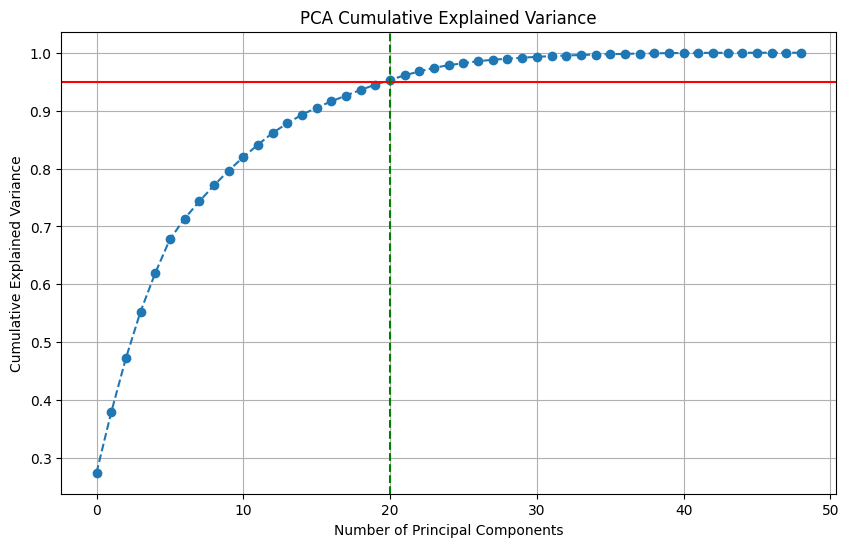

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    cumulative_variance,
    marker='o',
    linestyle='--'
)

# 95% variance threshold
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components_95 - 1, color='g', linestyle='--')

plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [61]:
import os, json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

import joblib

OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [62]:
# Apply PCA with optimal number of components (95% variance)
pca = PCA(n_components=n_components_95, random_state=42)
X_pca = pca.fit_transform(X_selected)

X_pca.shape

(82332, 21)

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((65865, 21), (16467, 21))

In [64]:
print("Original selected features:", X_selected.shape[1])
print("After PCA:", X_pca.shape[1])
print("Explained variance:", pca.explained_variance_ratio_.sum())

Original selected features: 50
After PCA: 21
Explained variance: 0.9531421652812652


In [65]:
# Step 4: Baseline Model Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

In [66]:
# Model Training
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train, y_train)

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmu

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [67]:
# Generate Predictions and Evaluate Model Performance
y_pred = log_reg.predict(X_test) 
y_proba = log_reg.predict_proba(X_test)[:, 1]

/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/erecongco/.pyenv/versions/tfenv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [68]:
logreg_metrics = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_proba)
}

logreg_metrics

{'Model': 'Logistic Regression',
 'Accuracy': 0.9860326714034129,
 'Precision': 0.9869943789264852,
 'Recall': 0.9876475129590824,
 'F1': 0.9873208379272327,
 'ROC_AUC': np.float64(0.9984737941868194)}

In [69]:

# 4.1.4 Print Classification Report
print (classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      7400
      Attack       0.99      0.99      0.99      9067

    accuracy                           0.99     16467
   macro avg       0.99      0.99      0.99     16467
weighted avg       0.99      0.99      0.99     16467



In [70]:
#4.2.1: Train Random Forest non-linear model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,          # sufficient trees for stability
    max_depth=20,              # prevents overfitting
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

rf

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=20, min_samples_split=50,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [71]:
#4.2.2: Evaluate Random Forest model

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
rf_metrics = {
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC_AUC": roc_auc_score(y_test, y_proba_rf)
}

rf_metrics

{'Model': 'Random Forest',
 'Accuracy': 0.990405052529301,
 'Precision': 0.9882714019511126,
 'Recall': 0.9943752067938679,
 'F1': 0.9913139087410665,
 'ROC_AUC': np.float64(0.9995944604580317)}

In [86]:
#4.2.3 Feature Importance from Random Forest

import pandas as pd
import numpy as np

rf_importance = pd.DataFrame({
    "Feature_Index": range(X_train.shape[1]),
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

rf_importance.head(10)

,Feature_Index,Importance
0,0,0.135083
5,5,0.101102
4,4,0.098541
9,9,0.077802
12,12,0.075126
8,8,0.074867
15,15,0.059145
14,14,0.055925
10,10,0.051480
7,7,0.046377


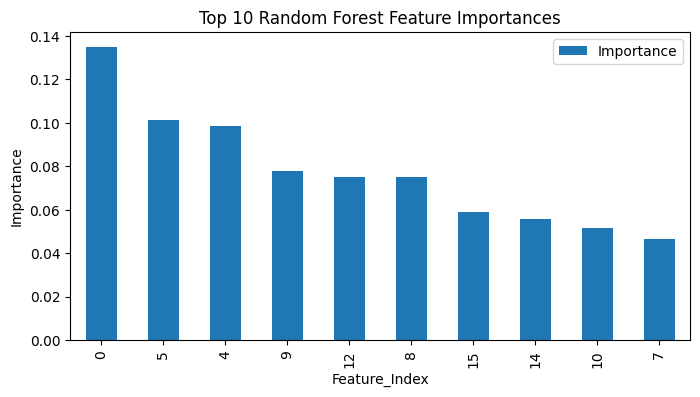

In [87]:
#4.2.4: Visualize Top Important Features

import matplotlib.pyplot as plt

rf_importance.head(10).plot(
    x="Feature_Index",
    y="Importance",
    kind="bar",
    figsize=(8, 4),
    title="Top 10 Random Forest Feature Importances"
)

plt.ylabel("Importance")
plt.show()

In [88]:
#4.3 Evaluate Logistic Regression

# Classification Report

print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      7400
      Attack       0.99      0.99      0.99      9067

    accuracy                           0.99     16467
   macro avg       0.99      0.99      0.99     16467
weighted avg       0.99      0.99      0.99     16467



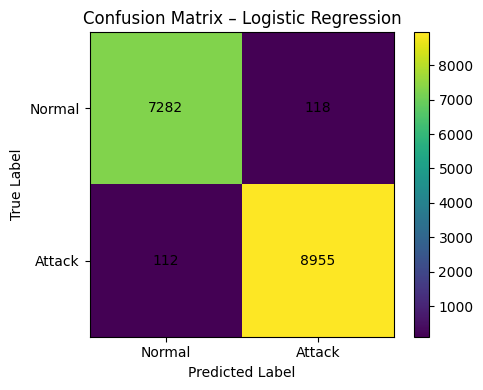

In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix – Logistic Regression")
plt.colorbar()
plt.xticks([0,1], ["Normal", "Attack"])
plt.yticks([0,1], ["Normal", "Attack"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

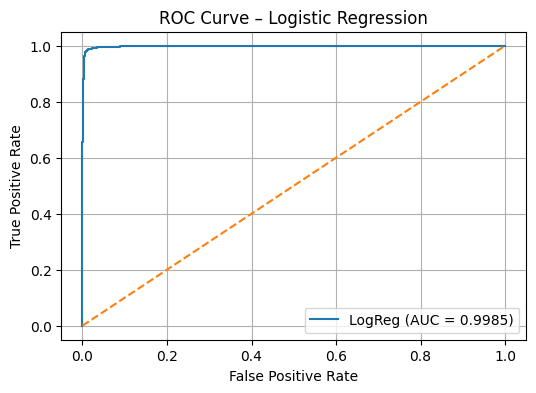

In [90]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {logreg_metrics['ROC_AUC']:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid()
plt.show()

In [91]:
#4.4 Decision Tree (Baseline Non-Linear)

#4.4.1 Train Decision Tree model

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=10,              # prevents overfitting
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=20, min_samples_split=50,
                       random_state=42)

In [92]:
#4.4.2 Predictions

y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

In [93]:
dt_metrics = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "ROC_AUC": roc_auc_score(y_test, y_proba_dt)
}

dt_metrics

{'Model': 'Decision Tree',
 'Accuracy': 0.9734013481508471,
 'Precision': 0.9805100790733935,
 'Recall': 0.9709937134664167,
 'F1': 0.9757286933392442,
 'ROC_AUC': np.float64(0.992170404108752)}

In [94]:
print(classification_report(y_test, y_pred_dt, target_names=["Normal", "Attack"]))

              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      7400
      Attack       0.98      0.97      0.98      9067

    accuracy                           0.97     16467
   macro avg       0.97      0.97      0.97     16467
weighted avg       0.97      0.97      0.97     16467



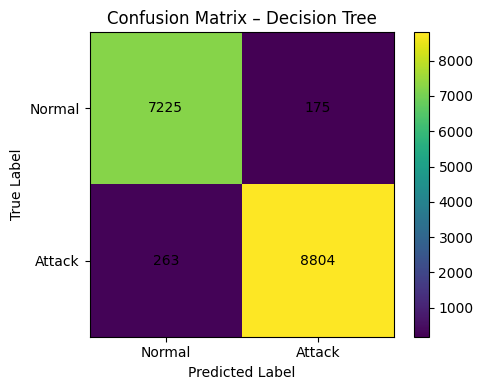

In [46]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(5, 4))
plt.imshow(cm_dt)
plt.title("Confusion Matrix – Decision Tree")
plt.colorbar()
plt.xticks([0,1], ["Normal", "Attack"])
plt.yticks([0,1], ["Normal", "Attack"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_dt[i, j], ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

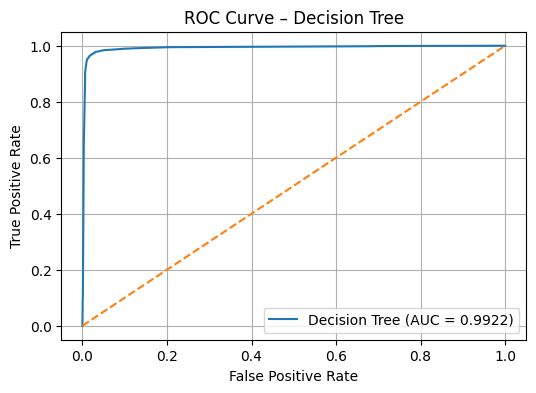

In [47]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {dt_metrics['ROC_AUC']:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.grid()
plt.show()

In [41]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

# Predictions
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Metrics dictionary (same structure as Logistic Regression)
dt_metrics = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "ROC_AUC": roc_auc_score(y_test, y_proba_dt)
}

dt_metrics

{'Model': 'Decision Tree',
 'Accuracy': 0.9734013481508471,
 'Precision': 0.9805100790733935,
 'Recall': 0.9709937134664167,
 'F1': 0.9757286933392442,
 'ROC_AUC': np.float64(0.992170404108752)}

In [39]:
dt_metrics = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "ROC_AUC": roc_auc_score(y_test, y_proba_dt)
}

dt_metrics

{'Model': 'Decision Tree',
 'Accuracy': 0.9734013481508471,
 'Precision': 0.9805100790733935,
 'Recall': 0.9709937134664167,
 'F1': 0.9757286933392442,
 'ROC_AUC': np.float64(0.992170404108752)}

In [40]:
print(classification_report(y_test, y_pred_dt, target_names=["Normal", "Attack"]))

              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      7400
      Attack       0.98      0.97      0.98      9067

    accuracy                           0.97     16467
   macro avg       0.97      0.97      0.97     16467
weighted avg       0.97      0.97      0.97     16467



In [21]:
# ===== Step 5.0: Prerequisites & sanity checks =====
import numpy as np
import pandas as pd

required = ["df", "X_train", "X_test", "y_train", "y_test"]
missing = [v for v in required if v not in globals()]
print("Missing:", missing)

# Check models you might have trained in Step 4
for m in ["log_reg", "rf", "dt"]:
    print(m, "->", "FOUND" if m in globals() else "missing")

# Show shapes if available
if "df" in globals():
    print("df shape:", df.shape)
if "X_train" in globals():
    print("X_train shape:", getattr(X_train, "shape", None))
if "X_test" in globals():
    print("X_test shape:", getattr(X_test, "shape", None))

Missing: ['X_train', 'X_test', 'y_train', 'y_test']
log_reg -> missing
rf -> missing
dt -> missing
df shape: (82332, 45)


In [22]:
# ===== Step A: Define X and y correctly =====

# Confirm label exists
print("label in df:", "label" in df.columns)

# Separate features and target
X = df.drop(columns=["label"])
y = df["label"]

X.shape, y.shape

label in df: True


((82332, 44), (82332,))

In [23]:
# ===== Step B.1: Identify feature types =====

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(exclude=["object"]).columns.tolist()

len(numeric_features), len(categorical_features)

(40, 4)

In [25]:
# ===== Step B.2: Build preprocessing pipeline =====

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['id', 'dur', 'spkts', 'dpkts', 'sbytes',
                                  'dbytes', 'rate', 'sttl', 'dttl', 'sload',
                                  'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt',
                                  'sjit', 'djit', 'swin', 'stcpb', 'dtcpb',
                                  'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
                                  'dmean', 'trans_depth', 'response_body_len',
                                  'ct_srv_src', 'ct_state_ttl', ...]),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['proto', 'service', 'state', 'attack_cat'])])

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((65865, 44), (16467, 44))

In [27]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

X_train_proc.shape, X_test_proc.shape

((65865, 201), (16467, 201))

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_proc, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [29]:
feature_names = preprocessor.get_feature_names_out()
len(feature_names), X_train_proc.shape[1]

(201, 201)

In [30]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame so SHAP shows feature names
X_test_df = pd.DataFrame(X_test_proc, columns=feature_names)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_df)

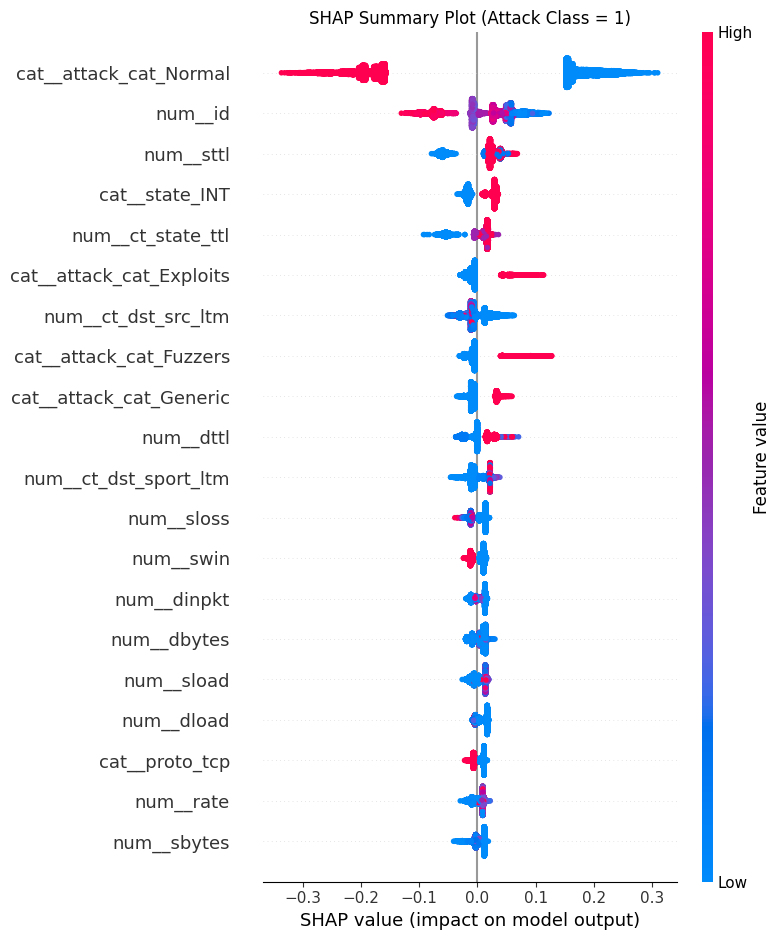

In [34]:
# Attack class = 1 is the 3rd dimension index 1
sv_attack = shap_values[:, :, 1]

shap.summary_plot(sv_attack, X_test_df, show=False)
plt.title("SHAP Summary Plot (Attack Class = 1)")
plt.tight_layout()
plt.show()

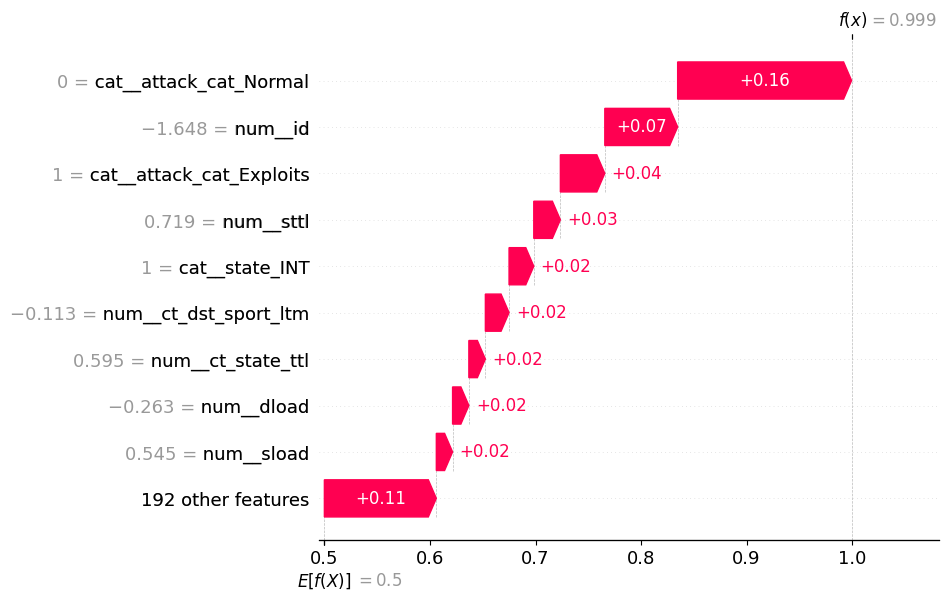

In [40]:
shap.waterfall_plot(
    shap.Explanation(
        values=sv_attack[i],
        base_values=explainer.expected_value[1],
        data=X_test_df.iloc[i],
        feature_names=X_test_df.columns
    )
)

In [33]:
print("X_test_df:", X_test_df.shape)

# What type/shape did SHAP return?
print("type(shap_values):", type(shap_values))

# If list (common)
if isinstance(shap_values, list):
    print("len(shap_values):", len(shap_values))
    for i, sv in enumerate(shap_values):
        print(f"shap_values[{i}] shape:", sv.shape)
else:
    print("shap_values shape:", shap_values.shape)

X_test_df: (16467, 201)
type(shap_values): <class 'numpy.ndarray'>
shap_values shape: (16467, 201, 2)


In [35]:
# ============================================================
# Step 5.3 — Bias & Fairness Audit (Proxy Groups)
# UNSW-NB15 has no human-sensitive attributes, so I audit
# fairness across NETWORK proxy groups: proto / service / state.
# Metrics: Demographic Parity (selection rate) + Equalized Odds (TPR/FPR gaps)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# ---------- A) Pick a proxy "sensitive" group column ----------
# Choose ONE first (recommended: 'proto'). You can repeat for 'service' and 'state'.
GROUP_COL = "proto"   # try: "proto" or "service" or "state"

assert GROUP_COL in X_test.columns, f"{GROUP_COL} not found in X_test columns. Available: {list(X_test.columns)[:10]}..."

# ---------- B) Get predictions from your trained model ----------
# Trained rf on X_train_proc, so we must preprocess X_test before predicting.
y_true = y_test.values

y_pred = rf.predict(X_test_proc)
# Probabilities help for threshold-based mitigation later
y_proba = rf.predict_proba(X_test_proc)[:, 1]

# Group labels aligned with X_test rows
g = X_test[GROUP_COL].astype(str).values

# ---------- C) Helper: compute fairness metrics per group ----------
def group_metrics(y_true, y_pred, group_values):
    """
    Returns a DataFrame with:
    - n, base_rate (attack prevalence)
    - selection_rate (P(ŷ=1))
    - TPR, FPR
    plus global gaps (max-min) for:
    - selection_rate (Demographic Parity gap)
    - TPR and FPR (Equalized Odds gaps)
    """
    rows = []
    unique_groups = pd.Series(group_values).value_counts().index.tolist()

    for gv in unique_groups:
        mask = (group_values == gv)
        yt = y_true[mask]
        yp = y_pred[mask]

        # Confusion matrix in binary: [ [TN, FP], [FN, TP] ]
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()

        n = mask.sum()
        base_rate = yt.mean() if n > 0 else np.nan
        selection_rate = yp.mean() if n > 0 else np.nan

        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

        rows.append({
            "group": gv,
            "n": int(n),
            "base_rate_attack": float(base_rate),
            "selection_rate_pred_attack": float(selection_rate),
            "TPR": float(tpr),
            "FPR": float(fpr)
        })

    dfm = pd.DataFrame(rows)

    # Gaps (max-min)
    dp_gap = dfm["selection_rate_pred_attack"].max() - dfm["selection_rate_pred_attack"].min()
    tpr_gap = dfm["TPR"].max() - dfm["TPR"].min()
    fpr_gap = dfm["FPR"].max() - dfm["FPR"].min()

    summary = pd.DataFrame([{
        "metric": "GAPS (max-min)",
        "DP_gap_selection_rate": float(dp_gap),
        "TPR_gap": float(tpr_gap),
        "FPR_gap": float(fpr_gap),
        "note": "DP gap = Demographic Parity (selection rate) gap; TPR/FPR gaps = Equalized Odds components"
    }])

    return dfm.sort_values("n", ascending=False).reset_index(drop=True), summary

# ---------- D) Run the audit ----------
group_table, gap_summary = group_metrics(y_true, y_pred, g)

print("=== Fairness audit by group:", GROUP_COL, "===")
display(group_table.head(15))
display(gap_summary)

# ---------- E) Focus on groups with enough samples ----------
MIN_N = 200  # adjust if needed
group_table_filtered = group_table[group_table["n"] >= MIN_N].copy()

dp_gap_f = group_table_filtered["selection_rate_pred_attack"].max() - group_table_filtered["selection_rate_pred_attack"].min()
tpr_gap_f = group_table_filtered["TPR"].max() - group_table_filtered["TPR"].min()
fpr_gap_f = group_table_filtered["FPR"].max() - group_table_filtered["FPR"].min()

print(f"Filtered gaps (n >= {MIN_N}):")
print("DP gap:", dp_gap_f)
print("TPR gap:", tpr_gap_f)
print("FPR gap:", fpr_gap_f)

=== Fairness audit by group: proto ===


,group,n,base_rate_attack,selection_rate_pred_attack,TPR,FPR
0,tcp,8650,0.355491,0.355491,1.0,0.0
1,udp,5865,0.727707,0.727707,1.0,0.0
2,unas,678,1.000000,1.000000,1.0,NaN
3,arp,206,0.000000,0.000000,NaN,0.0
4,ospf,141,0.914894,0.914894,1.0,0.0
5,sctp,64,1.000000,1.000000,1.0,NaN
6,pim,19,1.000000,1.000000,1.0,NaN
7,any,17,1.000000,1.000000,1.0,NaN
8,smp,14,1.000000,1.000000,1.0,NaN
9,ipcv,13,1.000000,1.000000,1.0,NaN


,metric,DP_gap_selection_rate,TPR_gap,FPR_gap,note
0,GAPS (max-min),1.0,0.0,0.0,DP gap = Demographic Parity (selection rate) g...


Filtered gaps (n >= 200):
DP gap: 1.0
TPR gap: 0.0
FPR gap: 0.0
